# Figures for fits to UHECR data

Here, we use the output from the `fits_to_data` notebook to plot the figures shown in the paper. Here, we show the result for the SBG catalogue, but the other two cases can be created by switching the catalogue in the `fits_to_data` notebook.
<br>
<br>
*This code was used to produce Figures 9, 10, 11 and 12 in Capel & Mortlock (2019)*.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('minimalist')

from fancy import Data, Results
from fancy.detector.auger2014 import detector_properties
from fancy.plotting import AllSkyMap
from fancy.plotting.colours import lightblue, midblue, midblue_contour, darkblue, purple, grey
from fancy.plotting import Corner
from fancy.interfaces.stan import Direction

In [2]:
# Define data files
source_file = '../data/sourcedata.h5'
uhecr_file = '../data/UHECRdata.h5'

source_type = "2FHL_250Mpc"

# Define output files
# arrival_output_file = 'output/arrival_fit.h5'
# joint_output_file = 'output/joint_fit.h5'
arrival_output_file = 'output/arrival_fit_{0}_PAO.h5'.format(source_type)
joint_output_file = 'output/joint_fit_{0}_PAO.h5'.format(source_type)

## Info used in a few plots

In [3]:
data = Data()

# Choose catalogue
data.add_source(source_file, source_type)
source_label = '2FHL' # For plot lables

data.add_uhecr(uhecr_file, 'auger2014')
data.add_detector(detector_properties)

source_direction = Direction(data.source.unit_vector)
arrival_direction = Direction(data.uhecr.unit_vector)
energy = data.uhecr.energy

In [4]:
# Legend
legend_elements = [mpl.lines.Line2D([0], [0], marker = 'o', color = 'w', 
                                    label = source_label, markersize = 10, 
                                    markerfacecolor = 'k'),
                   mpl.lines.Line2D([0], [0], marker = 'o', color='w', 
                                    label = 'UHECRs', markersize = 15, 
                                    markerfacecolor = midblue, alpha = 0.8)]

# UHECRs
uhecr_color = [lightblue, midblue, darkblue]
uhecr_cmap = mpl.colors.ListedColormap(uhecr_color)
energy_bins = np.logspace(np.log(52), np.log(128), 4, base = np.e)
uhecr_norm = mpl.colors.BoundaryNorm(energy_bins, uhecr_cmap.N)

## Figure 9
Source catalogues and Auger UHECRs

In [5]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [6]:
# Exposure
num_points = 10000
rightascensions = np.linspace(-180, 180, num_points)
limiting_dec = data.detector.limiting_dec.deg
boundary_decs = np.tile(limiting_dec, num_points)
c = SkyCoord(ra = rightascensions * u.degree,
             dec = boundary_decs * u.degree, frame = 'icrs')
exp_lon = c.galactic.l.deg
exp_lat = c.galactic.b.deg

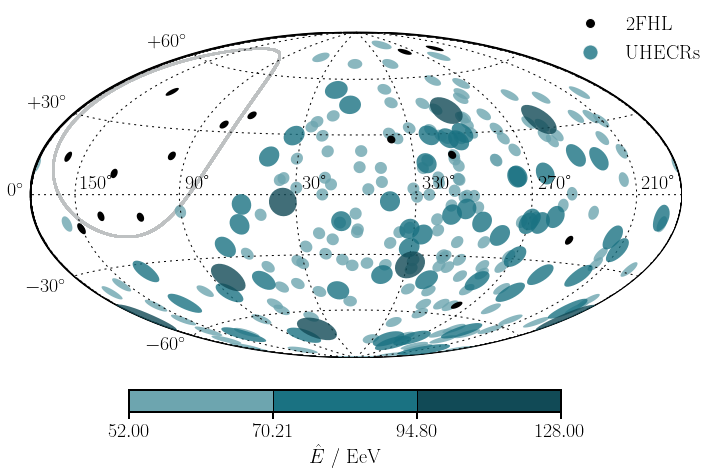

In [7]:
# Figure
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);

# Sources
for lon, lat in np.nditer([source_direction.lons, source_direction.lats]):
    skymap.tissot(lon, lat, 2.0, 30, facecolor = 'k', alpha = 1.0, zorder = 5)
    
# UHECRs
for lon, lat, E in np.nditer([arrival_direction.lons, arrival_direction.lats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(lon, lat, 3.0 + (i*2), 30, 
                  facecolor = uhecr_cmap.colors[i], alpha = 0.8, zorder = i+2)
    
# Exposure
# Uses scatter as bug with AllSkyMap.pcolormesh and contour that I still need to fix...
skymap.scatter(exp_lon, exp_lat, latlon = True, s = 2,
               color = grey, alpha = 1)
        
# Annotation
skymap.draw_border()
skymap.draw_standard_labels(minimal = True, fontsize = 20)
ax.legend(handles = legend_elements, bbox_to_anchor = (0.8, 0.85), fontsize = 20)

# Colorbar
cb_ax = plt.axes([0.25, 0, .5, .05], frameon = False)
bar = mpl.colorbar.ColorbarBase(cb_ax, norm = uhecr_norm, cmap = uhecr_cmap,
                                orientation = 'horizontal', drawedges = True, 
                                alpha = 1)
bar.set_label('$\hat{E}$ / EeV', color = 'k', fontsize = 20)
bar.ax.tick_params(labelsize=20)

## Figure 10
Comparison between arrival direction and joint model.

In [8]:
# Larger fontsize
plt.rcParams['font.size'] = 22
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

In [9]:
# Get f samples for both models and true f value.
f_a = Results(arrival_output_file).get_chain(['f'])['f']
f_j = Results(joint_output_file).get_chain(['f'])['f']

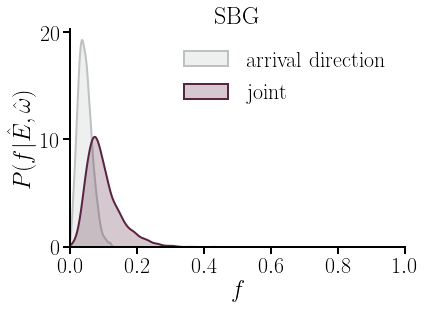

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 4))

sns.distplot(f_a, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 0}, 
             color = grey, label = 'arrival direction')
sns.distplot(f_j, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 1}, 
             color = purple, label = 'joint')

ax.set_xlim(0, 1)
ax.set_title(source_label, fontsize = 24)
ax.set_xlabel('$f$')
ax.set_ylabel('$P(f | \hat{E}, \hat{\omega})$')
ax.legend(fontsize = 22);

## Figure 11
The association probabilities of source-UHECR pairs from the fit of the joint model. See Appendix B for how these are calculated. 

In [11]:
# Log probability
results = Results(joint_output_file)
keys = ['lp']
chain = results.get_chain(keys);
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]

# Account for background component
Ns = np.shape(logprob)[1] - 1

In [12]:
# Calculate association probabilities for each source-UHECR combo
uhecr_p = []
for lp in logprob:
    lps = []
    for src in range(Ns + 1):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns+1):
        ps.append(lps[src] / norm)
    uhecr_p.append(ps)

# Normalise line weights
pmax = max(max(uhecr_p))

In [13]:
# Find names of dominant sources
threshold_probability = 0.1

dominant = []
for p in uhecr_p:
    for i in range(data.source.N):
        if p[i] > threshold_probability:
            dominant.append(i)

seen = set()
inds = []
for d in dominant:
    if d not in seen:
        inds.append(d)
        seen.add(d)
print([data.source.name[i] for i in inds])

[b'2FHL J1325.6-4301']


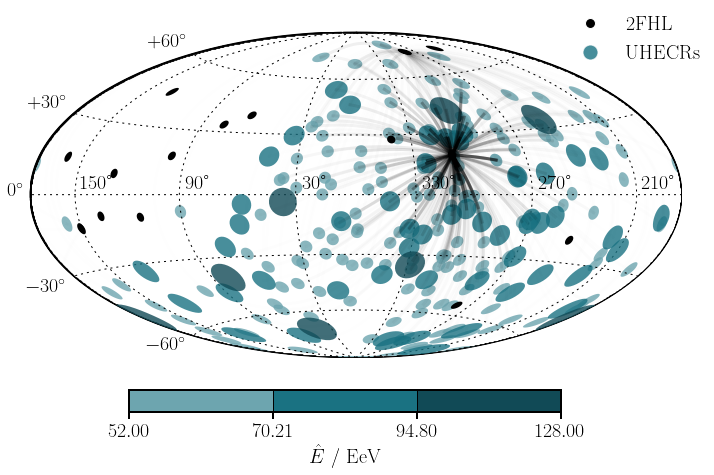

In [14]:
# Figure
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);

# Sources
for lon, lat in np.nditer([source_direction.lons, source_direction.lats]):
    skymap.tissot(lon, lat, 2.0, 30, facecolor = 'k', alpha = 1.0, zorder = 5)
    
# UHECRs
for lon, lat, E in np.nditer([arrival_direction.lons, arrival_direction.lats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(lon, lat, 3.0 + (i*2), 30, 
                  facecolor = uhecr_cmap.colors[i], alpha = 0.8, zorder = i+2)
    
# Association
for i, p in enumerate(uhecr_p):
    for j, psrc in enumerate(p[0:Ns]):
        if psrc > 0.001:
            skymap.geodesic(arrival_direction.lons[i], arrival_direction.lats[i], 
                            source_direction.lons[j], source_direction.lats[j], 
                            color = 'k', lw = 3, alpha = psrc/pmax, zorder = 10)

# Annotation
skymap.draw_border()
skymap.draw_standard_labels(minimal = True, fontsize = 20)
ax.legend(handles = legend_elements, bbox_to_anchor = (0.8, 0.85), fontsize = 20)

# Colorbar
cb_ax = plt.axes([0.25, 0, .5, .05], frameon = False)
bar = mpl.colorbar.ColorbarBase(cb_ax, norm = uhecr_norm, cmap = uhecr_cmap,
                                orientation = 'horizontal', drawedges = True, 
                                alpha = 1)
bar.set_label('$\hat{E}$ / EeV', color = 'k', fontsize = 20)
bar.ax.tick_params(labelsize = 20)

## Figure 12

Joint marginal posterior distribution of hyperparamaters for the joint_model fit. 

In [15]:
from pandas import DataFrame

In [16]:
# Get chains from joint fit 
results_fit = Results(joint_output_file)

keys = ['alpha', 'B', 'f']
chain = results_fit.get_chain(keys)

labels = {}
labels['B'] = r'$B$ / $\mathrm{nG}$'
labels['alpha'] = r'$\alpha$'
labels['f'] = r'$f$'

In [17]:
# Make nicely labelled dict
chain_for_df = {}
for key in keys:
    chain_for_df[labels[key]] = chain[key]

# Make ordered dataframe
df = DataFrame(data = chain_for_df)
df = df[[labels['alpha'], labels['B'], labels['f']]]

In [18]:
corner = Corner(df, color = midblue, contour_color=midblue_contour)